## Adjusting weights for unit test data after moving to `cvx.sum_squares` in `solardatatools.signal_decompositions`

### Progress
- ~~l2_l1d1_l2d2p365~~
- l1_l2d2p365
- tl1_l2d2p365
- ~~tl1_l1d1_l2d2p365~~
- make_l2_l1d2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import random
import json
import seaborn as sns


from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from utils import plot_decomp, plot_signal
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

In [2]:
or_dir = "./tests_io_cvxpy_norm/"

In [3]:
weight_results = {}

## `l2_l1d1_l2d2p365`

Tests:
- test_l2_l1d1_l2d2p365_default
- test_l2_l1d1_l2d2p365_tv_weights
- test_l2_l1d1_l2d2p365_transition
- test_l2_l1d1_l2d2p365_transition_wrong
- test_l2_l1d1_l2d2p365_default_long
- test_l2_l1d1_l2d2p365_idx_select
- test_l2_l1d1_l2d2p365_yearly_periodic

### `test_l2_l1d1_l2d2p365_default`

5.01, 100.0000, 0.1780, 0.1599
5.01, 226.2275, 0.1908, 0.1732
5.01, 511.7890, 0.1562, 0.1368
5.01, 1157.8075, 0.1386, 0.1157
5.01, 2619.2793, 0.1194, 0.0993
5.01, 5925.5310, 0.0824, 0.0683
5.01, 13405.1824, 0.0584, 0.0502
5.01, 30326.2131, 0.0458, 0.0449
5.01, 68606.2429, 0.1021, 0.0981
5.01, 155206.2089, 0.2220, 0.2094
5.01, 351119.1734, 0.3788, 0.3517
5.01, 794328.2347, 0.5234, 0.4823
5.84, 100.0000, 0.1881, 0.1759
5.84, 226.2275, 0.1836, 0.1721
5.84, 511.7890, 0.1620, 0.1517
5.84, 1157.8075, 0.1179, 0.1037
5.84, 2619.2793, 0.0962, 0.0754
5.84, 5925.5310, 0.0733, 0.0563
5.84, 13405.1824, 0.0540, 0.0437
5.84, 30326.2131, 0.0488, 0.0453
5.84, 68606.2429, 0.0590, 0.0560
5.84, 155206.2089, 0.1517, 0.1441
5.84, 351119.1734, 0.3134, 0.2929
5.84, 794328.2347, 0.4717, 0.4358
6.81, 100.0000, 0.2263, 0.2161
6.81, 226.2275, 0.1980, 0.1885
6.81, 511.7890, 0.1757, 0.1666
6.81, 1157.8075, 0.1250, 0.1162
6.81, 2619.2793, 0.0873, 0.0749
6.81, 5925.5310, 0.0734, 0.0541
6.81, 13405.1824, 0.0576, 0.046

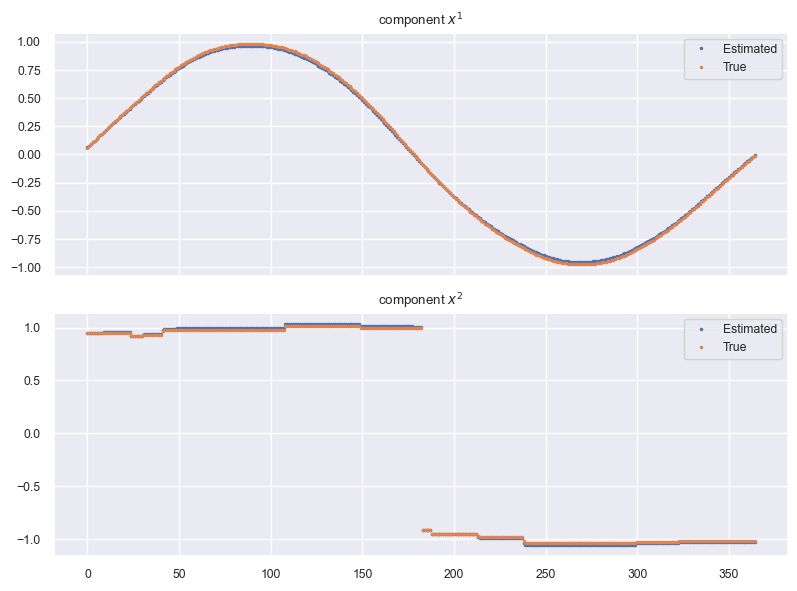

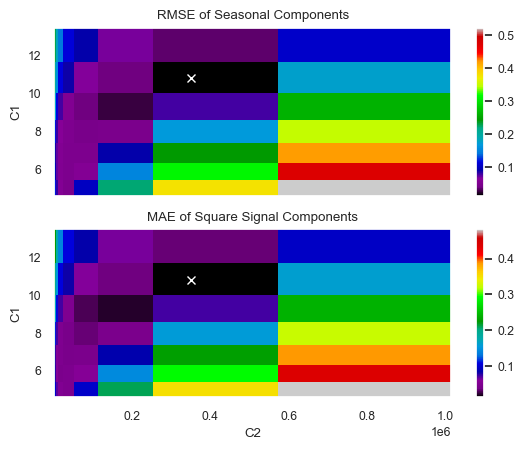

In [4]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_default_input.json"
output_file = "test_l2_l1d1_l2d2p365_default_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_signal = json.load(f)["test_signal"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)

or_s_hat = data["expected_s_hat_mosek_365"]
or_s_seas = data["expected_s_seas_mosek_365"]


# Set weight ranges to search over
# Original weights: c1= 2, c2=500

# c1_weights = np.logspace(1, 1.5, 10)
# c2_weights = np.logspace(3, 5.7, 10)

c1_weights = np.logspace(0.7, 1.1, 7)
c2_weights = np.logspace(2, 5.9, 12)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(input_data), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          return_obj=True)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")
            
# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)

# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')

plt.show()

### `test_l2_l1d1_l2d2p365_tv_weights` 

10.00, 1000.0000, 0.2348, 0.2290
10.00, 1759.7645, 0.1958, 0.1903
10.00, 3096.7710, 0.1588, 0.1535
10.00, 5449.5876, 0.1175, 0.1121
10.00, 9589.9906, 0.0808, 0.0749
10.00, 16876.1248, 0.0530, 0.0467
10.00, 29698.0048, 0.0321, 0.0252
10.00, 52261.4937, 0.0169, 0.0076
10.00, 91967.9199, 0.0202, 0.0168
10.00, 161841.8779, 0.0368, 0.0346
10.00, 284803.5868, 0.0588, 0.0565
10.00, 501187.2336, 0.0987, 0.0911
10.43, 1000.0000, 0.2482, 0.2427
10.43, 1759.7645, 0.2075, 0.2022
10.43, 3096.7710, 0.1689, 0.1638
10.43, 5449.5876, 0.1310, 0.1262
10.43, 9589.9906, 0.0922, 0.0873
10.43, 16876.1248, 0.0627, 0.0577
10.43, 29698.0048, 0.0406, 0.0357
10.43, 52261.4937, 0.0230, 0.0178
10.43, 91967.9199, 0.0111, 0.0048
10.43, 161841.8779, 0.0243, 0.0228
10.43, 284803.5868, 0.0484, 0.0469
10.43, 501187.2336, 0.0849, 0.0789
10.87, 1000.0000, 0.2623, 0.2571
10.87, 1759.7645, 0.2196, 0.2146
10.87, 3096.7710, 0.1793, 0.1746
10.87, 5449.5876, 0.1419, 0.1375
10.87, 9589.9906, 0.1044, 0.1002
10.87, 16876.1248, 0.07

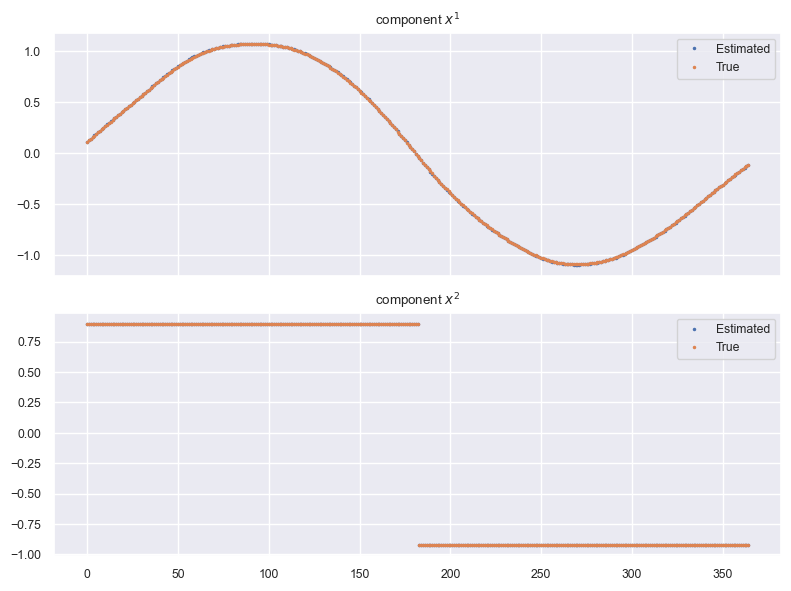

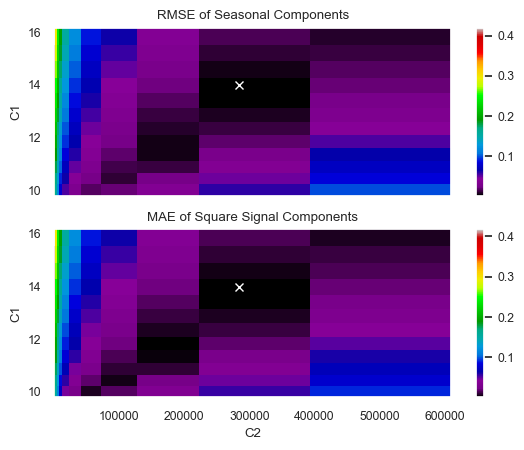

In [5]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_tv_weights_input.json"
output_file = "test_l2_l1d1_l2d2p365_tv_weights_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
rand_tv_weights = input_data["rand_tv_weights_365"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_tvw_365"]
or_s_seas = data["expected_s_seas_mosek_tvw_365"]


# Set weight ranges to search over
# Original weights: c1= 2.5, c2=500

c1_weights = np.logspace(1, 1.2, 12)
c2_weights = np.logspace(3, 5.7, 12)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(test_signal), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          tv_weights=rand_tv_weights,
                                                          return_obj=True)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")
            
# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)

# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_l2_l1d1_l2d2p365_transition`

10.00, 1000.0000, 0.0309, 0.0191
10.00, 1873.8174, 0.0253, 0.0156
10.00, 3511.1917, 0.0203, 0.0126
10.00, 6579.3322, 0.0163, 0.0107
10.00, 12328.4674, 0.0128, 0.0091
10.00, 23101.2970, 0.0091, 0.0071
10.00, 43287.6128, 0.0040, 0.0034
10.00, 81113.0831, 0.0044, 0.0039
10.00, 151991.1083, 0.0187, 0.0170
10.00, 284803.5868, 0.0433, 0.0395
10.00, 533669.9231, 0.0849, 0.0774
10.00, 1000000.0000, 0.1551, 0.1409
****True here is original component****


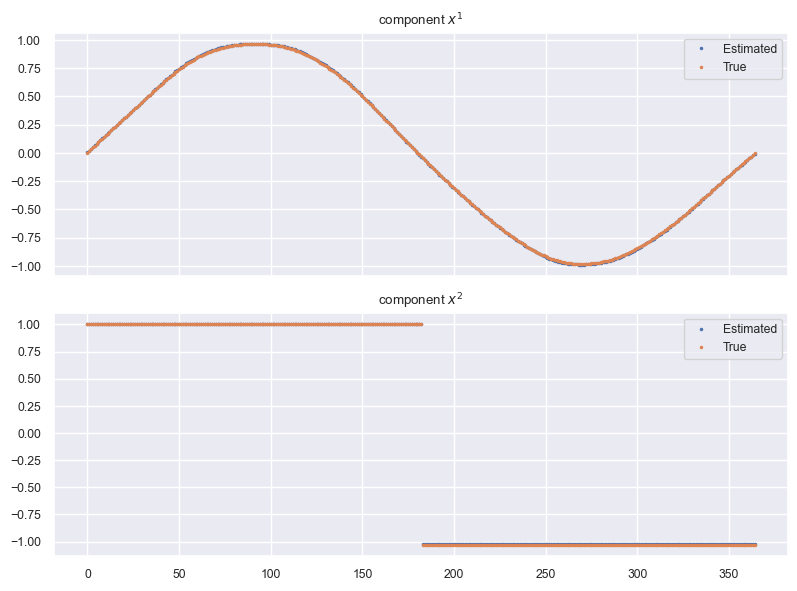

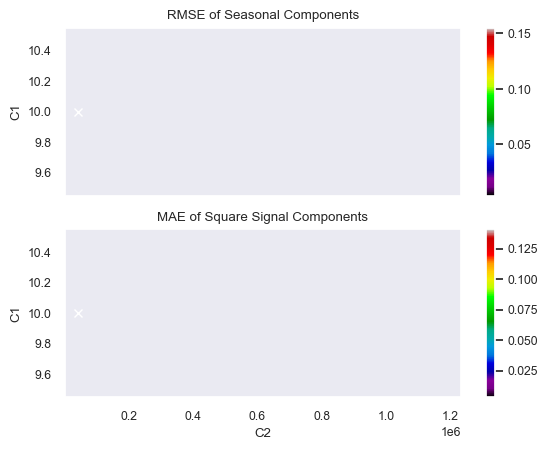

In [6]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_transition_input.json"
output_file = "test_l2_l1d1_l2d2p365_transition_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
indices = input_data["indices"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_transition_365"]
or_s_seas = data["expected_s_seas_mosek_transition_365"]


# Set weight ranges to search over
# Original weights: c1=10, c2=500

c1_weights = np.logspace(1, 1, 1)
c2_weights = np.logspace(3, 6, 12)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(test_signal), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          transition_locs=indices,
                                                          return_obj=True)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_l2_l1d1_l2d2p365_transition_wrong`

****True here is original component****


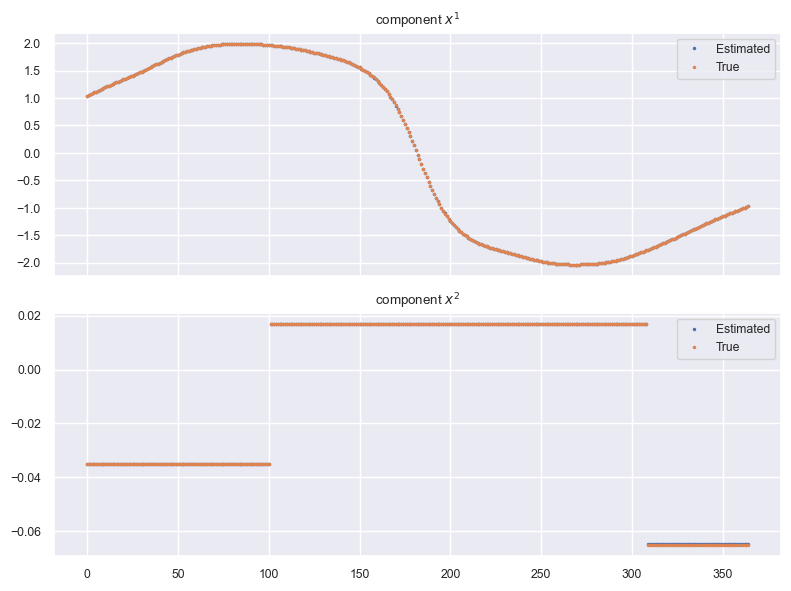

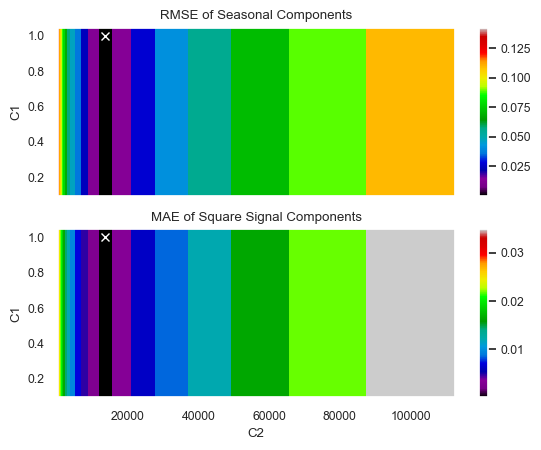

In [7]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_transition_wrong_input.json"
output_file = "test_l2_l1d1_l2d2p365_transition_wrong_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
indices = input_data["indices"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_transition_wrong_365"]
or_s_seas = data["expected_s_seas_mosek_transition_wrong_365"]


# Set weight ranges to search over
# Original weights: c1=10, c2=500

c1_weights = np.logspace(-1, 0, 25)
c2_weights = np.logspace(2, 5, 25)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(test_signal), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          transition_locs=indices,
                                                          return_obj=True)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b

        if a<=min_seas or b<=min_shat :
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
        #     print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        # else:
        #     print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_l2_l1d1_l2d2p365_default_long`

10.00, 10000.0000, 0.0559, 0.0489
10.00, 20733.2157, 0.0460, 0.0403
10.00, 42986.6235, 0.0377, 0.0344
10.00, 89125.0938, 0.0238, 0.0226
10.00, 184784.9797, 0.0293, 0.0291
10.00, 383118.6850, 0.0947, 0.0890
10.00, 794328.2347, 0.2367, 0.2180
12.12, 10000.0000, 0.0671, 0.0614
12.12, 20733.2157, 0.0532, 0.0486
12.12, 42986.6235, 0.0417, 0.0377
12.12, 89125.0938, 0.0262, 0.0231
12.12, 184784.9797, 0.0095, 0.0093
12.12, 383118.6850, 0.0518, 0.0495
12.12, 794328.2347, 0.1474, 0.1364
14.68, 10000.0000, 0.0850, 0.0809
14.68, 20733.2157, 0.0652, 0.0616
14.68, 42986.6235, 0.0504, 0.0473
14.68, 89125.0938, 0.0355, 0.0329
14.68, 184784.9797, 0.0133, 0.0120
14.68, 383118.6850, 0.0193, 0.0186
14.68, 794328.2347, 0.0875, 0.0812
17.78, 10000.0000, 0.1097, 0.1071
17.78, 20733.2157, 0.0843, 0.0823
17.78, 42986.6235, 0.0647, 0.0632
17.78, 89125.0938, 0.0477, 0.0465
17.78, 184784.9797, 0.0291, 0.0283
17.78, 383118.6850, 0.0027, 0.0028
17.78, 794328.2347, 0.0472, 0.0432
21.54, 10000.0000, 0.1437, 0.1426
21

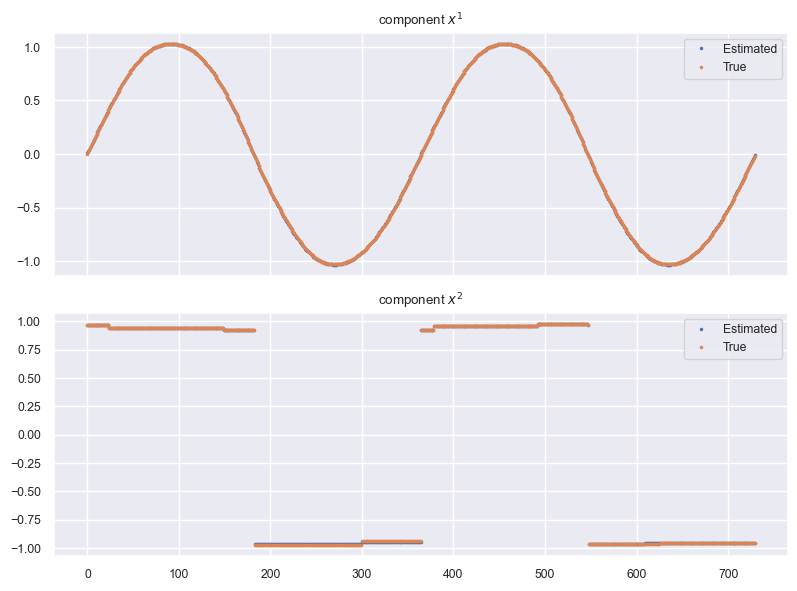

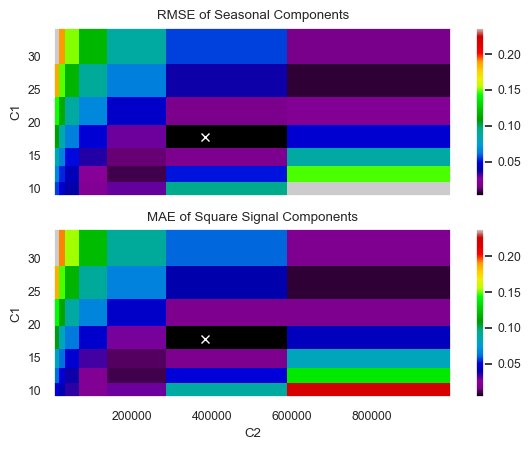

In [8]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_default_long_input.json"
output_file = "test_l2_l1d1_l2d2p365_default_long_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek"]
or_s_seas = data["expected_s_seas_mosek"]


# Set weight ranges to search over
# Original weights: c1=2, c2=500

c1_weights = np.logspace(1, 1.5, 7)
c2_weights = np.logspace(4, 5.9, 7)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(test_signal), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          return_obj=True)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_l2_l1d1_l2d2p365_idx_select`

10.00, 10000.0000, 0.0684, 0.0622
10.00, 13688.7451, 0.0639, 0.0583
10.00, 18738.1742, 0.0595, 0.0544
10.00, 25650.2091, 0.0551, 0.0503
10.00, 35111.9173, 0.0499, 0.0455
10.00, 48063.8086, 0.0434, 0.0394
10.00, 65793.3225, 0.0357, 0.0321
10.00, 90062.8020, 0.0258, 0.0228
10.00, 123284.6739, 0.0129, 0.0111
10.00, 168761.2476, 0.0074, 0.0094
10.00, 231012.9700, 0.0279, 0.0282
10.00, 316227.7660, 0.0465, 0.0453
11.10, 10000.0000, 0.0798, 0.0745
11.10, 13688.7451, 0.0736, 0.0683
11.10, 18738.1742, 0.0684, 0.0634
11.10, 25650.2091, 0.0631, 0.0586
11.10, 35111.9173, 0.0575, 0.0533
11.10, 48063.8086, 0.0511, 0.0472
11.10, 65793.3225, 0.0432, 0.0398
11.10, 90062.8020, 0.0333, 0.0304
11.10, 123284.6739, 0.0211, 0.0189
11.10, 168761.2476, 0.0056, 0.0046
11.10, 231012.9700, 0.0130, 0.0137
11.10, 316227.7660, 0.0303, 0.0296
12.33, 10000.0000, 0.0928, 0.0886
12.33, 13688.7451, 0.0842, 0.0800
12.33, 18738.1742, 0.0779, 0.0738
12.33, 25650.2091, 0.0723, 0.0681
12.33, 35111.9173, 0.0666, 0.0626
12.33,

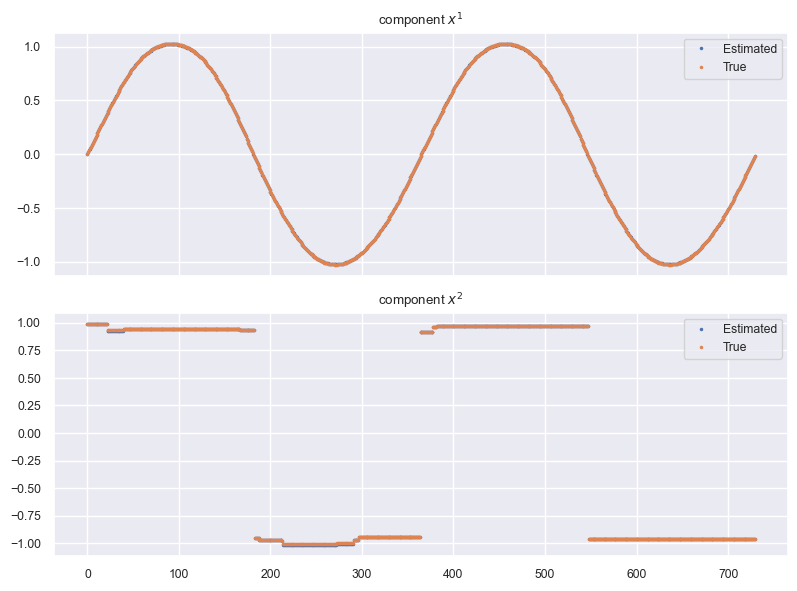

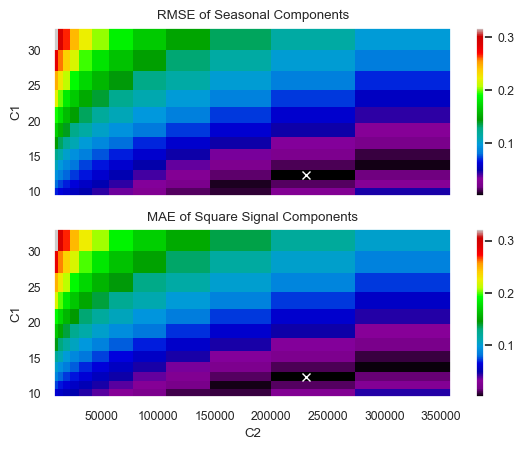

In [9]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_idx_select_input.json"
output_file = "test_l2_l1d1_l2d2p365_idx_select_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
indices = input_data["indices"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_ixs"]
or_s_seas = data["expected_s_seas_mosek_ixs"]


# Set weight ranges to search over
# Original weights: c1=2, c2=500

c1_weights = np.logspace(1, 1.5, 12)
c2_weights = np.logspace(4, 5.5, 12)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(test_signal), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          return_obj=True,
                                                          use_ixs=indices)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_l2_l1d1_l2d2p365_yearly_periodic`

3.16, 100000.0000, 0.0796, 0.0738
3.16, 111033.6318, 0.0971, 0.0897
3.16, 123284.6739, 0.1171, 0.1079
3.16, 136887.4510, 0.1382, 0.1267
3.16, 151991.1083, 0.1599, 0.1464
3.16, 168761.2476, 0.1842, 0.1683
3.16, 187381.7423, 0.2091, 0.1907
3.16, 208056.7538, 0.2340, 0.2130
3.16, 231012.9700, 0.2588, 0.2352
3.16, 256502.0906, 0.2847, 0.2582
3.16, 284803.5868, 0.3099, 0.2808
3.16, 316227.7660, 0.3342, 0.3027
3.51, 100000.0000, 0.0408, 0.0389
3.51, 111033.6318, 0.0551, 0.0521
3.51, 123284.6739, 0.0715, 0.0666
3.51, 136887.4510, 0.0897, 0.0830
3.51, 151991.1083, 0.1118, 0.1028
3.51, 168761.2476, 0.1345, 0.1233
3.51, 187381.7423, 0.1577, 0.1442
3.51, 208056.7538, 0.1826, 0.1665
3.51, 231012.9700, 0.2094, 0.1904
3.51, 256502.0906, 0.2355, 0.2138
3.51, 284803.5868, 0.2609, 0.2368
3.51, 316227.7660, 0.2866, 0.2600
3.90, 100000.0000, 0.0199, 0.0214
3.90, 111033.6318, 0.0239, 0.0237
3.90, 123284.6739, 0.0330, 0.0324
3.90, 136887.4510, 0.0470, 0.0449
3.90, 151991.1083, 0.0655, 0.0611
3.90, 168761.2

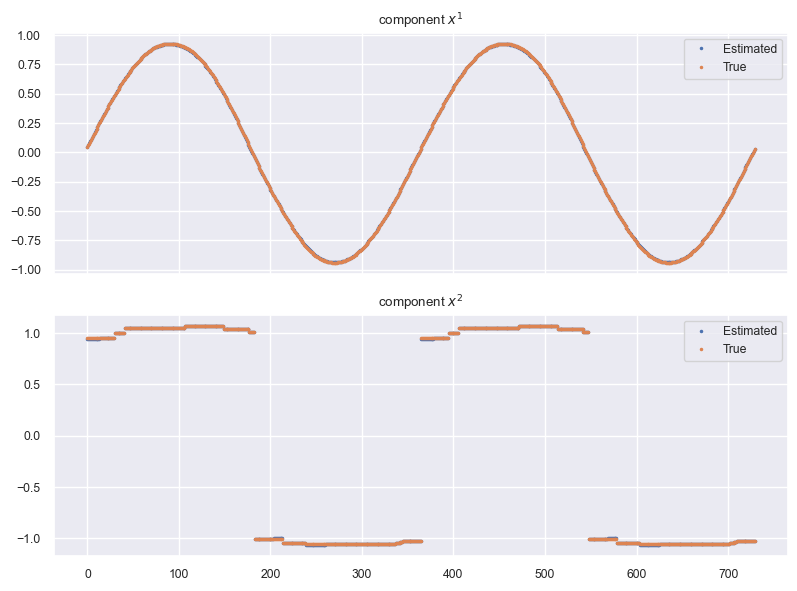

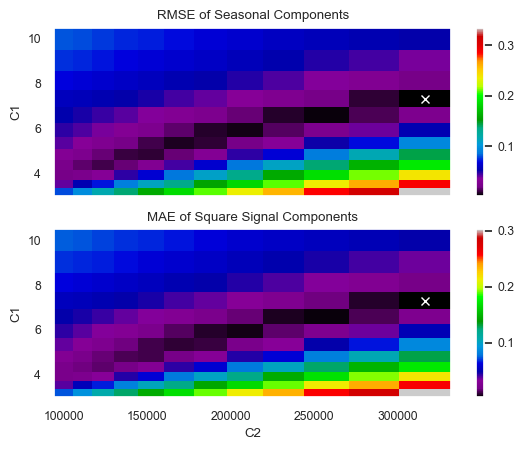

In [10]:
# Load original data
input_file = "test_l2_l1d1_l2d2p365_yearly_periodic_input.json"
output_file = "test_l2_l1d1_l2d2p365_yearly_periodic_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_yearly_periodic"]
or_s_seas = data["expected_s_seas_mosek_yearly_periodic"]


# Set weight ranges to search over
# Original weights: c1=1, c2=500

c1_weights = np.logspace(0.5, 1, 12)
c2_weights = np.logspace(5, 5.5, 12)


def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.l2_l1d1_l2d2p365(np.array(test_signal), 
                                                          c1=c1, 
                                                          c2=c2, 
                                                          solver = "MOSEK", 
                                                          return_obj=True,
                                                          yearly_periodic=True)
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

# ------------------------------------------------------------

## `tl1_l1d1_l2d2p365`

Tests:
- test_tl1_l1d1_l2d2p365_default
- test_tl1_l1d1_l2d2p365_idx_select
- test_tl1_l1d1_l2d2p365_tv_weights

### `test_tl1_l1d1_l2d2p365_default`

3.16, 10000.0000, 0.0643, 0.0595
3.16, 12915.4967, 0.0340, 0.0286
3.16, 16681.0054, 0.0213, 0.0106
3.16, 21544.3469, 0.0225, 0.0116
3.16, 27825.5940, 0.0202, 0.0187
3.16, 35938.1366, 0.0310, 0.0313
3.16, 46415.8883, 0.0374, 0.0376
3.16, 59948.4250, 0.0440, 0.0440
3.16, 77426.3683, 0.0612, 0.0601
3.16, 100000.0000, 0.0770, 0.0723
3.41, 10000.0000, 0.0780, 0.0739
3.41, 12915.4967, 0.0461, 0.0428
3.41, 16681.0054, 0.0265, 0.0204
3.41, 21544.3469, 0.0216, 0.0094
3.41, 27825.5940, 0.0169, 0.0141
3.41, 35938.1366, 0.0206, 0.0208
3.41, 46415.8883, 0.0320, 0.0329
3.41, 59948.4250, 0.0402, 0.0410
3.41, 77426.3683, 0.0473, 0.0479
3.41, 100000.0000, 0.0644, 0.0630
3.69, 10000.0000, 0.0835, 0.0803
3.69, 12915.4967, 0.0547, 0.0524
3.69, 16681.0054, 0.0377, 0.0341
3.69, 21544.3469, 0.0173, 0.0097
3.69, 27825.5940, 0.0142, 0.0093
3.69, 35938.1366, 0.0174, 0.0164
3.69, 46415.8883, 0.0191, 0.0194
3.69, 59948.4250, 0.0311, 0.0320
3.69, 77426.3683, 0.0347, 0.0358
3.69, 100000.0000, 0.0433, 0.0444
3.98, 1

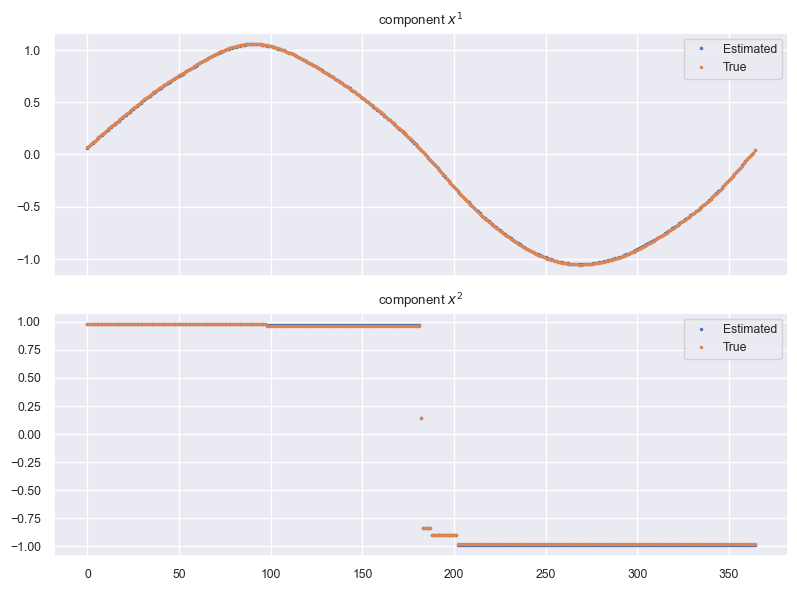

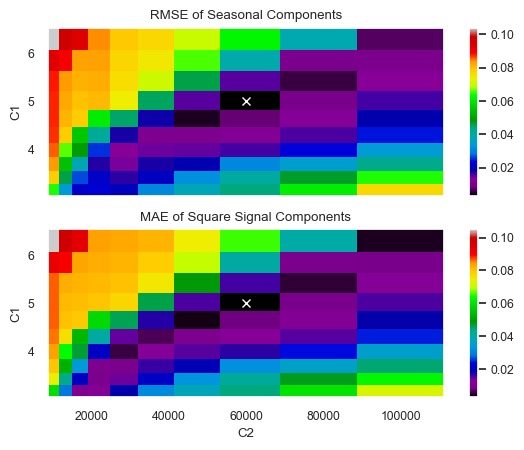

In [11]:
# Load original data
input_file = "test_tl1_l1d1_l2d2p365_default_input.json"
output_file = "test_tl1_l1d1_l2d2p365_default_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_365"]
or_s_seas = data["expected_s_seas_mosek_365"]


# Set weight ranges to search over
# Original weights: tau=0.8, c1=5, c2=500, c3=100

c1_weights = np.logspace(0.5, 0.8, 10)
c2_weights = np.logspace(4, 5, 10)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.tl1_l1d1_l2d2p365(np.array(test_signal),
                                                          tau=0.8,
                                                          c1=c1, 
                                                          c2=c2,
                                                          c3=100,
                                                          solver = "MOSEK", 
                                                          return_obj=True
                                                          )
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_tl1_l1d1_l2d2p365_idx_select`

3.16, 10000.0000, 0.0255, 0.0259
3.16, 12915.4967, 0.0290, 0.0360
3.16, 16681.0054, 0.0345, 0.0414
3.16, 21544.3469, 0.0444, 0.0504
3.16, 27825.5940, 0.0590, 0.0643
3.16, 35938.1366, 0.0875, 0.0921
3.16, 46415.8883, 0.1130, 0.1173
3.16, 59948.4250, 0.1224, 0.1263
3.16, 77426.3683, 0.1405, 0.1454
3.16, 100000.0000, 0.1546, 0.1578
3.41, 10000.0000, 0.0237, 0.0249
3.41, 12915.4967, 0.0284, 0.0346
3.41, 16681.0054, 0.0329, 0.0400
3.41, 21544.3469, 0.0408, 0.0473
3.41, 27825.5940, 0.0498, 0.0558
3.41, 35938.1366, 0.0663, 0.0716
3.41, 46415.8883, 0.0993, 0.1047
3.41, 59948.4250, 0.1147, 0.1200
3.41, 77426.3683, 0.1299, 0.1344
3.41, 100000.0000, 0.1436, 0.1487
3.69, 10000.0000, 0.0206, 0.0166
3.69, 12915.4967, 0.0242, 0.0270
3.69, 16681.0054, 0.0292, 0.0353
3.69, 21544.3469, 0.0375, 0.0439
3.69, 27825.5940, 0.0451, 0.0505
3.69, 35938.1366, 0.0543, 0.0596
3.69, 46415.8883, 0.0730, 0.0775
3.69, 59948.4250, 0.1016, 0.1066
3.69, 77426.3683, 0.1151, 0.1196
3.69, 100000.0000, 0.1353, 0.1395
3.98, 1

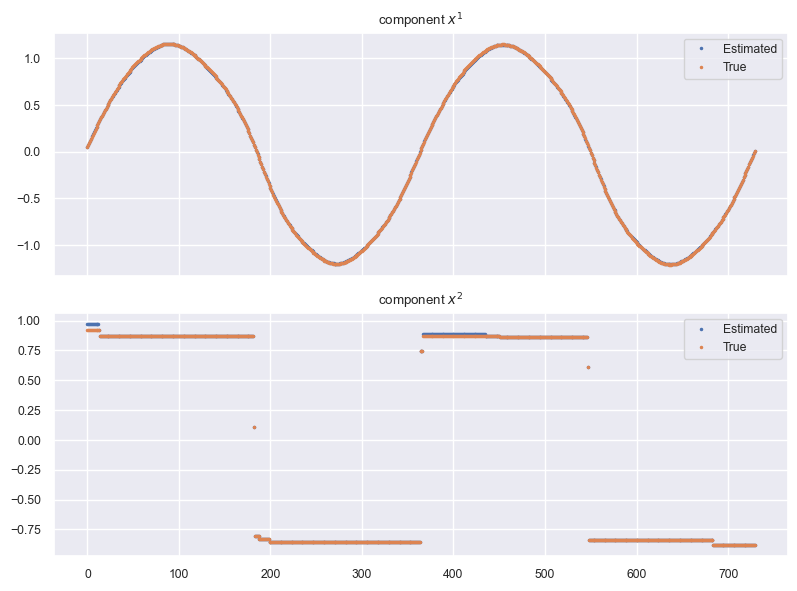

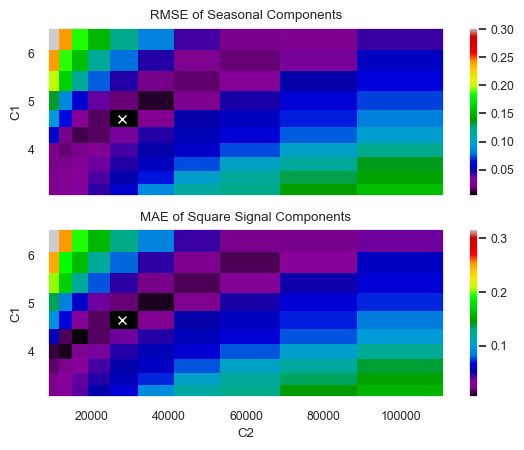

In [12]:
# Load original data
input_file = "test_tl1_l1d1_l2d2p365_idx_select_input.json"
output_file = "test_tl1_l1d1_l2d2p365_idx_select_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
indices = input_data["indices"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_ixs"]
or_s_seas = data["expected_s_seas_mosek_ixs"]


# Set weight ranges to search over
# Original weights: tau=0.8, c1=5, c2=500, c3=100

# c1_weights = np.logspace(-1, 1, 10)
# c2_weights = np.logspace(3.5, 4.5, 10)

c1_weights = np.logspace(0.5, 0.8, 10)
c2_weights = np.logspace(4, 5, 10)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.tl1_l1d1_l2d2p365(np.array(test_signal),
                                                          tau=0.8,
                                                          c1=c1, 
                                                          c2=c2,
                                                          c3=100,
                                                          solver = "MOSEK", 
                                                          return_obj=True,
                                                          use_ixs=indices
                                                          )
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

### `test_tl1_l1d1_l2d2p365_tv_weights`

3.16, 3162.2777, 0.0415, 0.0217
3.16, 4641.5888, 0.0335, 0.0151
3.16, 6812.9207, 0.0278, 0.0120
3.16, 10000.0000, 0.0207, 0.0065
3.16, 14677.9927, 0.0210, 0.0110
3.16, 21544.3469, 0.0319, 0.0283
3.16, 31622.7766, 0.0669, 0.0706
3.16, 46415.8883, 0.0838, 0.0897
3.16, 68129.2069, 0.0912, 0.0961
3.16, 100000.0000, 0.1118, 0.1177
3.50, 3162.2777, 0.0443, 0.0259
3.50, 4641.5888, 0.0336, 0.0152
3.50, 6812.9207, 0.0277, 0.0113
3.50, 10000.0000, 0.0224, 0.0064
3.50, 14677.9927, 0.0210, 0.0058
3.50, 21544.3469, 0.0265, 0.0233
3.50, 31622.7766, 0.0429, 0.0459
3.50, 46415.8883, 0.0774, 0.0831
3.50, 68129.2069, 0.0864, 0.0912
3.50, 100000.0000, 0.0942, 0.0992
3.88, 3162.2777, 0.0474, 0.0300
3.88, 4641.5888, 0.0381, 0.0196
3.88, 6812.9207, 0.0278, 0.0111
3.88, 10000.0000, 0.0228, 0.0068
3.88, 14677.9927, 0.0200, 0.0066
3.88, 21544.3469, 0.0137, 0.0035
3.88, 31622.7766, 0.0187, 0.0186
3.88, 46415.8883, 0.0568, 0.0614
3.88, 68129.2069, 0.0809, 0.0855
3.88, 100000.0000, 0.0886, 0.0932
4.30, 3162.2777,

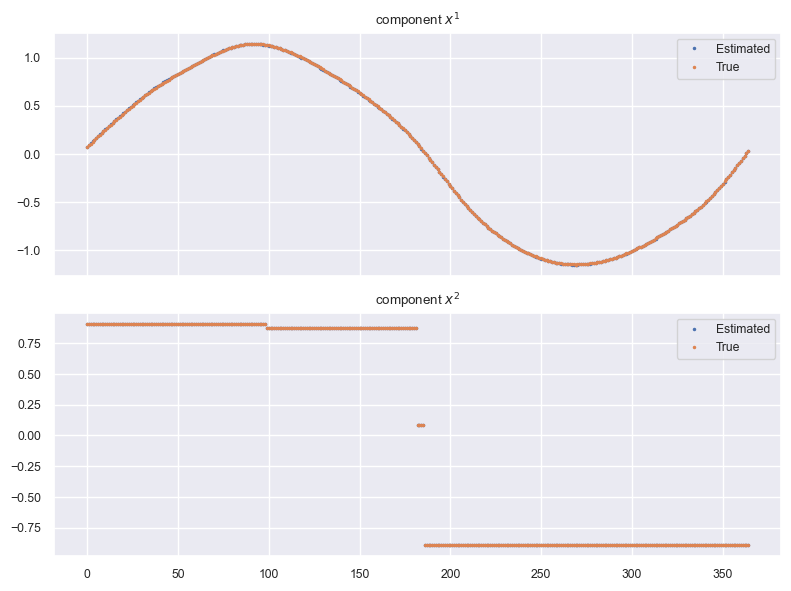

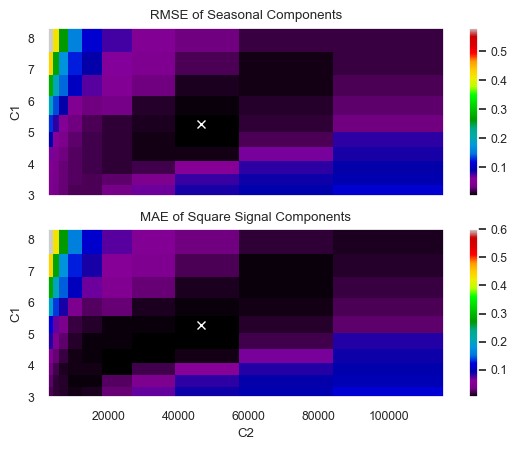

In [13]:
# Load original data
input_file = "test_tl1_l1d1_l2d2p365_tv_weights_input.json"
output_file = "test_tl1_l1d1_l2d2p365_tv_weights_output.json"

# input
with open(f"{or_dir}{input_file}") as f:
    input_data = json.load(f)
test_signal = input_data["test_signal"]
tv_weights = input_data["rand_tv_weights_365"]
    
# original decompositions
with open(f"{or_dir}{output_file}") as f:
    data = json.load(f)
or_s_hat = data["expected_s_hat_mosek_tvw_365"]
or_s_seas = data["expected_s_seas_mosek_tvw_365"]


# Set weight ranges to search over
# Original weights: tau=0.8, c1=5, c2=500, c3=100

c1_weights = np.logspace(0.5, 0.9, 10)
c2_weights = np.logspace(3.5, 5, 10)

def run_default_test( c1, c2, input_data=input_signal, or_s_hat=or_s_hat, or_s_seas=or_s_seas, plot=False):
    
    s_hat, s_seas, s_error, obj_val = sd.tl1_l1d1_l2d2p365(np.array(test_signal),
                                                          tau=0.8,
                                                          c1=c1, 
                                                          c2=c2,
                                                          c3=100,
                                                          solver = "MOSEK", 
                                                          return_obj=True,
                                                          tv_weights=tv_weights
                                                          )
    s_seas_rmse =  mse(s_seas, or_s_seas, squared=False)
    s_hat_mae = mae(s_hat, or_s_hat)

    if plot:
        plot_decomp([s_seas, s_hat], [or_s_seas, or_s_hat])
    return s_seas_rmse, s_hat_mae

min_c1, min_seas, min_shat = 1, 1, 1
res_seas = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 
res_shat = [[0 for x in range(len(c2_weights))] for y in range(len(c1_weights))] 

for i,c1 in enumerate(c1_weights):
    for j,c2 in enumerate(c2_weights):
        a, b = run_default_test(c1, c2)
        res_seas[i][j] = a
        res_shat[i][j] = b
        
        if a<=min_seas or b<=min_shat:
            min_seas = a
            min_shat = b
            c1_min, c2_min = c1, c2
            print(f"\x1b[31m{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}\x1b[0m")
        else:
            print(f"{c1:.2f}, {c2:.4f}, {a:.4f}, {b:.4f}")

# Save
weight_results[f"{input_file}"] = (c1_min, c2_min)
            
# Vizualize results
print("\033[1m\x1b[31m****True here is original component****\x1b[0m")
run_default_test(c1_min, c2_min, plot=True);

z1 = res_seas
x1, y1 = np.meshgrid(c2_weights, c1_weights)

z2 = res_shat
x2, y2 = np.meshgrid(c2_weights, c1_weights)

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
cmap = plt.colormaps['nipy_spectral']

im1 = ax1.pcolormesh(x1, y1, z1, cmap=cmap)
fig.colorbar(im1, ax=ax1)
ax1.plot(c2_min, c1_min, marker="x", color="white")
ax1.set_title('RMSE of Seasonal Components')
ax1.set_ylabel('C1')

im2 = ax2.pcolormesh(x2, y2, z2, cmap=cmap)
fig.colorbar(im2, ax=ax2)
ax2.plot(c2_min, c1_min, marker="x", color="white")
ax2.set_title('MAE of Square Signal Components')
ax2.set_xlabel('C2')
ax2.set_ylabel('C1')


plt.show()

# Trends

In [15]:
new_c1s = [i[0] for i in weight_results.values()]
new_c2s = [i[1] for i in weight_results.values()]

In [16]:
or_c1s = [2, 2.5, 10, 10, 2, 2, 1, 5, 5, 5]
or_c2s = [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]

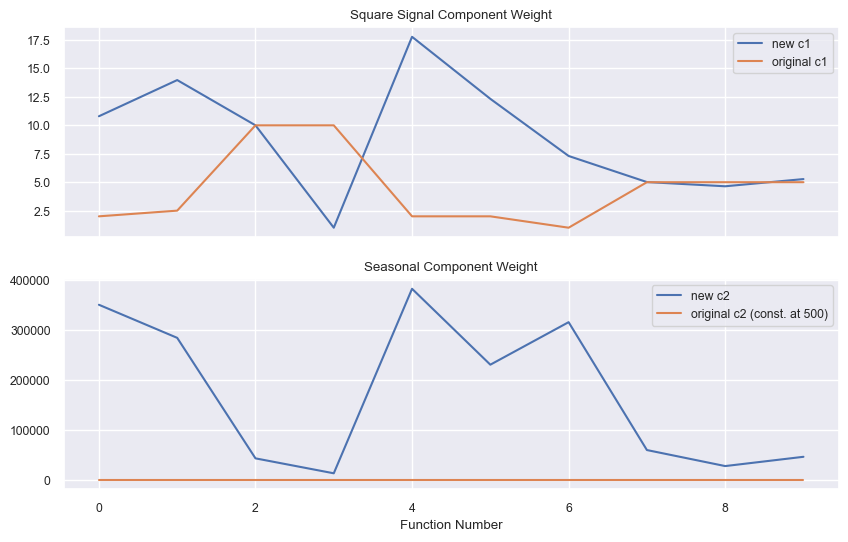

In [49]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,6))

ax1.plot(new_c1s, label="new c1")
ax1.plot(or_c1s, label="original c1")
ax1.set_title("Square Signal Component Weight")
ax1.legend();
ax2.plot(new_c2s, label="new c2")
ax2.plot(or_c2s, label="original c2 (const. at 500)")
ax2.set_title("Seasonal Component Weight")
ax2.set_xlabel("Function Number")
ax2.legend();